# Import Section
---

In [1]:
"""
# record_mcu.ipynb

This Jupyter Notebook is part of the `ML_audio_record` module and is used for recording audio data from a microcontroller unit (MCU).
The recorded data is stored in the `raw1` directory for further processing and analysis. User can update the directory name as needed.
For example, the user can change the directory name to your keyword label.

## Usage
Run each cell in the notebook sequentially to set up the MCU, configure recording parameters,
and start the recording process. Ensure that the MCU is properly connected before starting the notebook.
"""
import logging
import math
import os
import time as tt
import wave

import matplotlib.pyplot as plt
import numpy as np
from pyocd.core.helpers import ConnectHelper
from pyocd.flash.file_programmer import FileProgrammer
from scipy.io.wavfile import read, write

# MCU Record Section
---
- This part is the function that record your voice by mcu's microphone.
- The `*.bin` file is the mcu's running code for recording.
- The setting is total 7s to record.
- You can comment out `FileProgrammer(session).program("I2S_Codec_PDMA_SCA_max.bin")` after first time record for saving time and not flash every time recording.

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


class M460Record:
    """
    A class to handle recording operations for the M460 microcontroller.

    Attributes:
    buff_len : int
        The length of the buffer to store recorded data.
    sram_begain : int
        The starting address of the SRAM buffer.
    """

    def __init__(self):
        self.buff_len = 64000  # 4*16000
        self.sram_begain = 0x20000038  # s_au32PcmTxBuff

    def update_address(self, sram_begain, buff_len):
        """
        Updates the SRAM address and buffer length.

        """
        self.buff_len = buff_len
        self.sram_begain = sram_begain

    def recording(self):
        """
        Records audio for 7 seconds using the specified target and returns the recorded data.
        Returns:
            list: A list of 32-bit integers representing the recorded audio data.
        """

        with ConnectHelper.session_with_chosen_probe(
            target_override="m467hjhae"
        ) as session:

            board = session.board
            target = board.target

            FileProgrammer(session).program("I2S_Codec_PDMA_SCA_max.bin")

            target.reset(reset_type=target.ResetType.SW)
            print("Start to record 7s")

            tt.sleep(8)
            print("The record is finished, waiting for pulling data from board ...")
            # target.halt()

            st = tt.time()

            pmf32 = target.read_memory_block32(self.sram_begain, self.buff_len)

            ed = tt.time()
            print(f"Total pulling time: {(ed - st)}")
            print(f"Data size (Bytes): {len(pmf32)}")

            return pmf32  # return the sound array

# Transfer PCM data to WAV data
---
- This part is PCM data processing
- Detail:
         1. crop the default noise at first second.
         2. amplified the the wav data(optional, basing on bsp bin file).
         3. transfer from int32 to int16 (KWS is using int16).

In [3]:
class PcmWavPro:
    """
    A class to handle PCM to WAV file conversion and related operations.

    Attributes:
        amp (float): The amplitude factor for the PCM data.
        folder (str): The folder where the WAV files will be saved.
        filename (str): The name of the WAV file, generated based on the current time.
        filepath (str): The full path to the WAV file.
        sample_rate (int): The sample rate for the WAV file, default is 16000 Hz.
    """

    def __init__(self, amp, folder):
        self.amp = amp
        self.folder = folder  # default exist folder
        self.create_tag_folder(self.folder)
        _time = (str)(math.ceil(tt.time()))
        self.filename = _time + "_nohash"  # The filename is time, so it is unique
        self.filepath = os.path.join(self.folder, self.filename)
        self.sample_rate = 16000

    def create_tag_folder(self, tag_name):
        """
        Creates a folder with the specified tag name in the current working directory.

        Args:
            tag_name (str): The name of the folder to be created.

        Raises:
            OSError: If the folder cannot be created, an error message is printed and folder creation is skipped.
        """
        dir_path = os.path.join(os.getcwd(), tag_name)
        try:
            os.mkdir(dir_path)
        except OSError as error:
            print(error)
            print("skip create folder")

    def delete_32b(self):
        os.remove(self.filepath + "_int32.wav")

    def trans_16b(self):
        """
        Converts a 32-bit integer WAV file to a 16-bit integer WAV file and plots the waveforms.

        """
        rate, data = read(self.filepath + "_int32.wav")
        # print("Sample rate: {} Hz".format(rate))
        # print("Data type: {}".format(data.dtype))

        # transfer from int32 to int16
        write(self.filepath + ".wav", 16000, data.astype(np.int16))
        _, data_16 = read(self.filepath + ".wav")

        time = np.arange(0, len(data)) / rate
        plt.figure(figsize=(15, 5))

        plot_a = plt.subplot(211)
        plot_a.plot(time, data)
        plot_a.set_ylabel("Amplitude")
        plot_a.set_xlim(0, len(data) / rate)

        plot_b = plt.subplot(212)
        plot_b.plot(time, data_16)
        plot_b.set_ylabel("Amplitude")
        plot_b.set_xlim(0, len(data) / rate)

    def pcm2wav(self, pcmdata, wav_file, channels=1, bits=32):
        """
        Convert PCM data to WAV format and save it to a file.
        Args:
            pcmdata (bytes): The PCM data to be converted.
            wav_file (str): The path to the output WAV file.
            channels (int, optional): The number of audio channels. Defaults to 1.
            bits (int, optional): The number of bits per sample. Defaults to 32.
        Returns:
            None
        """

        wavfile = wave.open(wav_file, "wb")
        wavfile.setnchannels(channels)
        wavfile.setsampwidth(bits // 8)
        wavfile.setframerate(self.sample_rate)
        wavfile.writeframes(pcmdata)
        wavfile.close()

    def trans_wavfile(self, pmf32):
        """
        Transforms a given array of 32-bit floating point numbers into a WAV file.

        Parameters:
        pmf32 (list or numpy.ndarray): An array of 32-bit floating point numbers representing audio data.

        """
        arr = np.array(pmf32)
        arr_amp = arr * self.amp
        self.pcm2wav(arr_amp[8000:], self.filepath + "_int32.wav")

# Run Section
---
- The record file is save in `/raw` folder
- Collect all same label recording files at same folder and copy/move to `/ML_audio_aq`

[---|---|---|---|---|---|---|---|---|----]
[========================================]
Start to record 7s
The record is finished, waiting for pulling data from board ...
Total pulling time: 7.649043083190918
Data size (Bytes): 64000


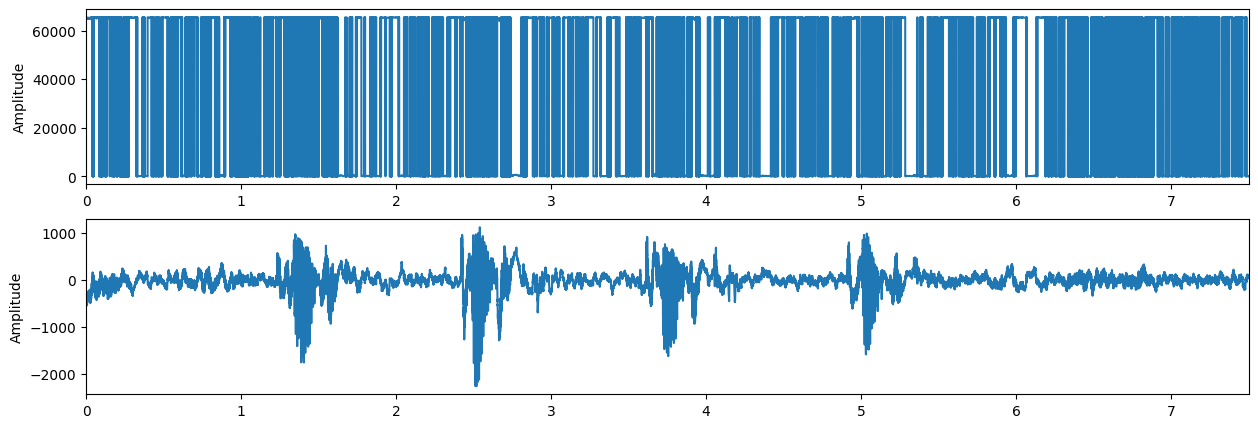

In [4]:
rd_m = M460Record()
pcm = rd_m.recording()

# Convert the 1 channel 32bits data(carry N(16bits) & N+1(16bits)) to N & N+1 data
pcm_buf_int32 = pcm

pcm_buf_int16 = []
for x in pcm_buf_int32:
    # s_pcm.append( x >> 16)
    pcm_buf_int16.append(x & 0x0000FFFF)
    pcm_buf_int16.append(((x & 0xFFFF0000) >> 16))

trans = PcmWavPro(1, "raw1")
trans.trans_wavfile(pcm_buf_int16)

trans.trans_16b()  # transfer to 16bits
trans.delete_32b()  # delete no use file

# Looping Record (Optional)
---
- This block help to record keyword more quickly. 
- It will continue `LOOPING_NUM` times to record, and each time is same as 7 (s).
- Please update `LOOPING_NUM` to decide how many time you want.

Start to record 8s
The record is finished, waiting for pulling data from board ...
Total pulling time: 4.163476228713989
Data size (Bytes): 64000
Start to record 8s
The record is finished, waiting for pulling data from board ...
Total pulling time: 4.083132982254028
Data size (Bytes): 64000
Start to record 8s
The record is finished, waiting for pulling data from board ...
Total pulling time: 4.157998323440552
Data size (Bytes): 64000
Start to record 8s
The record is finished, waiting for pulling data from board ...
Total pulling time: 4.1344709396362305
Data size (Bytes): 64000
Start to record 8s
The record is finished, waiting for pulling data from board ...
Total pulling time: 4.126887321472168
Data size (Bytes): 64000


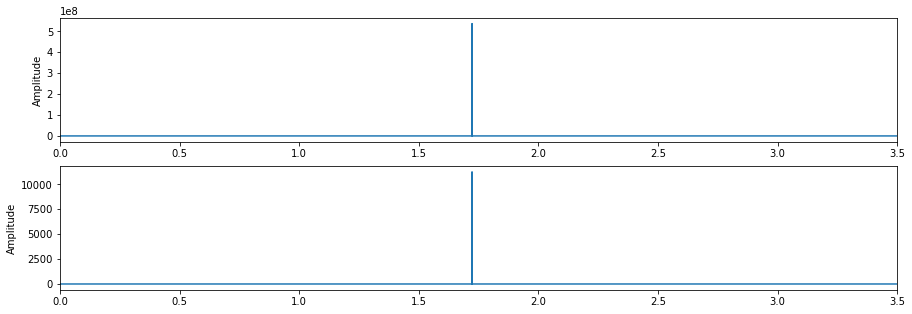

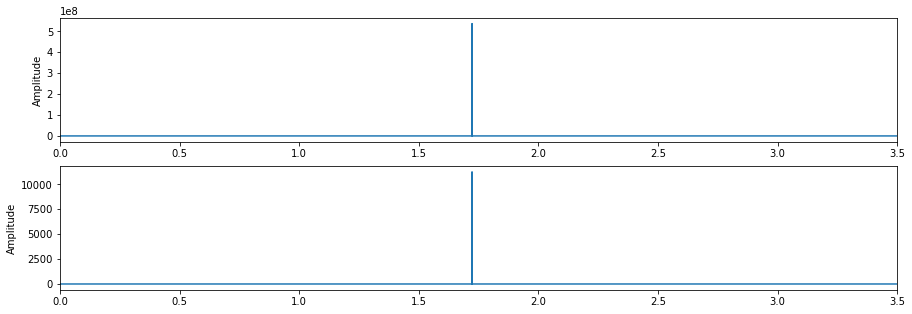

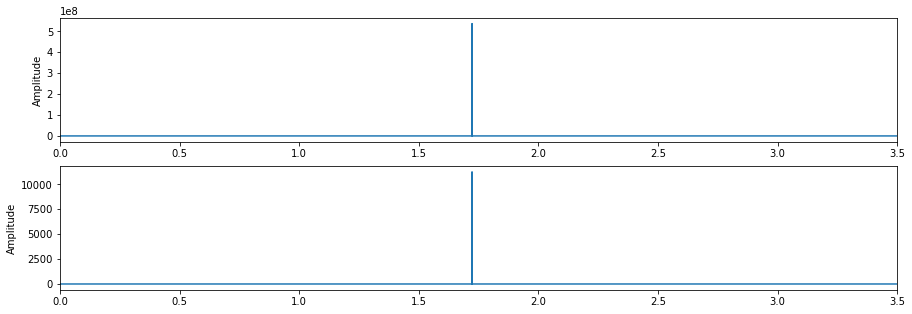

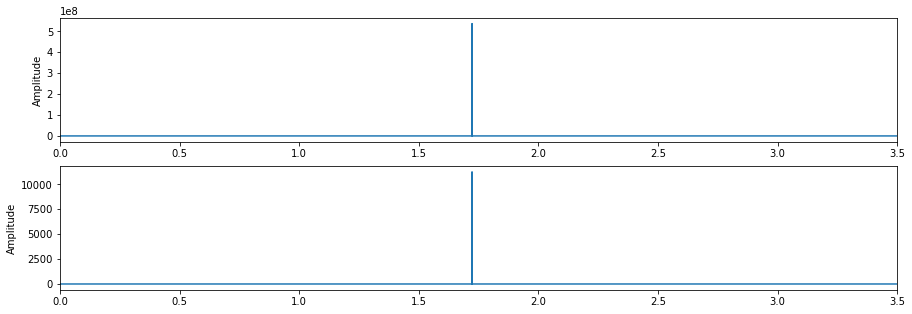

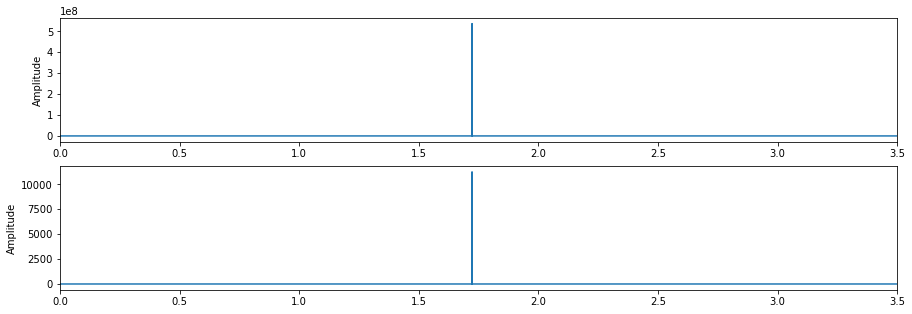

In [5]:
LOOPING_NUM = 5

for i in range(0, LOOPING_NUM):
    rd_m = M460Record()
    pcm = rd_m.recording()

    trans = PcmWavPro(1, "raw")
    trans.trans_wavfile(pcm)

    trans.trans_16b()  # transfer to 16bits
    trans.delete_32b()  # delete no use file

# Alternative way to pull and save the SRAM data (Optional)
---
- savemem command to bin file and readback the pmf array 

In [6]:
def cmd_savemem():
    """
    Executes a command to get data from memory from a microcontroller to a binary file and processes the saved data.

    """
    st = tt.time()
    !pyocd commander -t M467HJHAE -c "savemem 0x20000030 0x0000fa00 dump.bin"
    ed = tt.time()
    print(ed - st)

    with open("dump.bin", encoding="utf-8") as f:
        rectype = np.dtype(np.uint32)
        bdata = np.fromfile(f, dtype=rectype)

    print(len(bdata))


cmd_savemem()

Saved 64000 bytes to dump.bin
3.002626895904541
16000
